In [1]:
%load_ext nb_black
%load_ext autoreload

%autoreload 2

<IPython.core.display.Javascript object>

In [2]:
import os
from pathlib import Path

from requests import get
import pandas as pd
import numpy as np

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping

import logging

logging.basicConfig(level=logging.WARN)

<IPython.core.display.Javascript object>

In [3]:
from xplainet.input_utils import preproc_dataset
from xplainet.model import build_model
from xplainet.random_utils import setup_seed, SEED
from sklearn.model_selection import StratifiedShuffleSplit

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

%matplotlib inline

from zipfile import ZipFile

<IPython.core.display.Javascript object>

In [4]:
setup_seed()

<IPython.core.display.Javascript object>

In [5]:
def download(url, out, force=False, verify=True):
    out.parent.mkdir(parents=True, exist_ok=True)
    if force and out.exists():
        print(f"Removing file at {str(out)}")
        out.unlink()

    if out.exists():
        print("File already exists.")
        return
    print(f"Downloading {url} at {str(out)} ...")
    # open in binary mode
    with out.open(mode="wb") as file:
        # get request
        response = get(url, verify=verify)
        for chunk in response.iter_content(100000):
            # write to file
            file.write(chunk)


<IPython.core.display.Javascript object>

In [6]:
def plot_history(history):
    loss_list = [s for s in history.history.keys() if "loss" in s and "val" not in s]
    val_loss_list = [s for s in history.history.keys() if "loss" in s and "val" in s]
    acc_list = [s for s in history.history.keys() if "AUC" in s and "val" not in s]
    val_acc_list = [s for s in history.history.keys() if "AUC" in s and "val" in s]

    if len(loss_list) == 0:
        print("Loss is missing in history")
        return

    ## As loss always exists
    epochs = range(1, len(history.history[loss_list[0]]) + 1)

    ## Loss
    plt.figure(1)
    for l in loss_list:
        plt.plot(
            epochs,
            history.history[l],
            "b",
            label="Training loss ("
            + str(str(format(history.history[l][-1], ".5f")) + ")"),
        )
    for l in val_loss_list:
        plt.plot(
            epochs,
            history.history[l],
            "g",
            label="Validation loss ("
            + str(str(format(history.history[l][-1], ".5f")) + ")"),
        )

    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    plt.show()

<IPython.core.display.Javascript object>

## Bank marketing : loading data

In [7]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
dataset_name = "wine-quality"
out = Path(os.getcwd() + "/data/" + dataset_name + ".csv")

download(url, out)

target = "quality"
to_remove = []
train = pd.read_csv(out, sep=";", low_memory=False)

File already exists.


<IPython.core.display.Javascript object>

In [8]:
train.shape

(1599, 12)

<IPython.core.display.Javascript object>

In [9]:
train.columns

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality'],
      dtype='object')

<IPython.core.display.Javascript object>

In [10]:
if "Set" not in train.columns:
    print("Building tailored column")
    train_valid_index, test_index = next(
        StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=SEED).split(
            range(train[target].shape[0]), train[target].values
        )
    )
    train_index, valid_index = next(
        StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=SEED).split(
            train_valid_index, train[target].values[train_valid_index]
        )
    )
    train["Set"] = "train"
    train["Set"][valid_index] = "valid"
    train["Set"][test_index] = "test"
    # train.to_csv((out.parent / "train_bench.csv").as_posix(), index=False)

Building tailored column


/work/.cache/poetry/xplainet-KS9Ipbc1-py3.7/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/work/.cache/poetry/xplainet-KS9Ipbc1-py3.7/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/work/.cache/poetry/xplainet-KS9Ipbc1-py3.7/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexin

<IPython.core.display.Javascript object>

In [11]:
train_indices = train[train.Set == "train"].index
valid_indices = train[train.Set == "valid"].index
test_indices = train[train.Set == "test"].index

<IPython.core.display.Javascript object>

In [12]:
input_train, params = preproc_dataset(train.loc[train_indices], target, ["Set"])
params

{'constant_cols': [],
 'bool_cols': [],
 'num_cols': ['citric acid',
  'volatile acidity',
  'pH',
  'chlorides',
  'fixed acidity',
  'sulphates',
  'total sulfur dioxide',
  'residual sugar',
  'density'],
 'cat_cols': ['free sulfur dioxide', 'alcohol'],
 'num_encoder': [Pipeline(steps=[('fillna',
                   SimpleImputer(fill_value=-0.019274336038921036,
                                 strategy='constant')),
                  ('scaler', StandardScaler())]),
  Pipeline(steps=[('fillna',
                   SimpleImputer(fill_value=0.10203064783174609,
                                 strategy='constant')),
                  ('scaler', StandardScaler())]),
  Pipeline(steps=[('fillna',
                   SimpleImputer(fill_value=2.7247534703867524,
                                 strategy='constant')),
                  ('scaler', StandardScaler())]),
  Pipeline(steps=[('fillna',
                   SimpleImputer(fill_value=0.007052178701545107,
                                

<IPython.core.display.Javascript object>

In [13]:
len(train_indices)

1310

<IPython.core.display.Javascript object>

In [14]:
input_valid, _ = preproc_dataset(train.loc[valid_indices], target, ["Set"], params)
input_test, _ = preproc_dataset(train.loc[test_indices], target, ["Set"], params)

<IPython.core.display.Javascript object>

In [15]:
# target_encoder = LabelEncoder()

<IPython.core.display.Javascript object>

In [16]:
# train[target] = target_encoder.fit_transform(train[target].values.reshape(-1))
y_train = train[target].values[train_indices]
y_valid = train[target].values[valid_indices]
y_test = train[target].values[test_indices]

<IPython.core.display.Javascript object>

In [17]:
params

{'constant_cols': [],
 'bool_cols': [],
 'num_cols': ['citric acid',
  'volatile acidity',
  'pH',
  'chlorides',
  'fixed acidity',
  'sulphates',
  'total sulfur dioxide',
  'residual sugar',
  'density'],
 'cat_cols': ['free sulfur dioxide', 'alcohol'],
 'num_encoder': [Pipeline(steps=[('fillna',
                   SimpleImputer(fill_value=-0.019274336038921036,
                                 strategy='constant')),
                  ('scaler', StandardScaler())]),
  Pipeline(steps=[('fillna',
                   SimpleImputer(fill_value=0.10203064783174609,
                                 strategy='constant')),
                  ('scaler', StandardScaler())]),
  Pipeline(steps=[('fillna',
                   SimpleImputer(fill_value=2.7247534703867524,
                                 strategy='constant')),
                  ('scaler', StandardScaler())]),
  Pipeline(steps=[('fillna',
                   SimpleImputer(fill_value=0.007052178701545107,
                                

<IPython.core.display.Javascript object>

In [18]:
model = build_model(
    params,
    lconv_dim=[4],
    lconv_num_dim=[8],
    emb_size=16,
    activation_num_first_layer=None,  # "tanh",
    output_activation=None,
    output_dim=1,  # np.unique(y_train).shape[0],
)

/work/.cache/poetry/xplainet-KS9Ipbc1-py3.7/lib/python3.7/site-packages/tensorflow_addons/utils/resource_loader.py:103: UserWarning: You are currently using TensorFlow 2.3.0 and trying to load a custom op (custom_ops/activations/_activation_ops.so).
TensorFlow Addons has compiled its custom ops against TensorFlow 2.2.0, and there are no compatibility guarantees between the two versions. 
This means that you might get segfaults when loading the custom op, or other kind of low-level errors.
 If you do, do not file an issue on Github. This is a known limitation.

It might help you to fallback to pure Python ops with TF_ADDONS_PY_OPS . To do that, see https://github.com/tensorflow/addons#gpucpu-custom-ops 

You can also change the TensorFlow version installed on your system. You would need a TensorFlow version equal to or above 2.2.0 and strictly below 2.3.0.
 Note that nightly versions of TensorFlow, as well as non-pip TensorFlow like `conda install tensorflow` or compiled from source are

<IPython.core.display.Javascript object>

In [19]:
model.summary()

Model: "explainable_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_num (InputLayer)          [(None, 9)]          0                                            
__________________________________________________________________________________________________
input_cat (InputLayer)          [(None, 2)]          0                                            
__________________________________________________________________________________________________
reshape_num_input (Reshape)     (None, 9, 1)         0           input_num[0][0]                  
__________________________________________________________________________________________________
large_emb (Embedding)           (None, 2, 16)        1040        input_cat[0][0]                  
__________________________________________________________________________________

<IPython.core.display.Javascript object>

In [20]:
#!pip install pydot graphviz

<IPython.core.display.Javascript object>

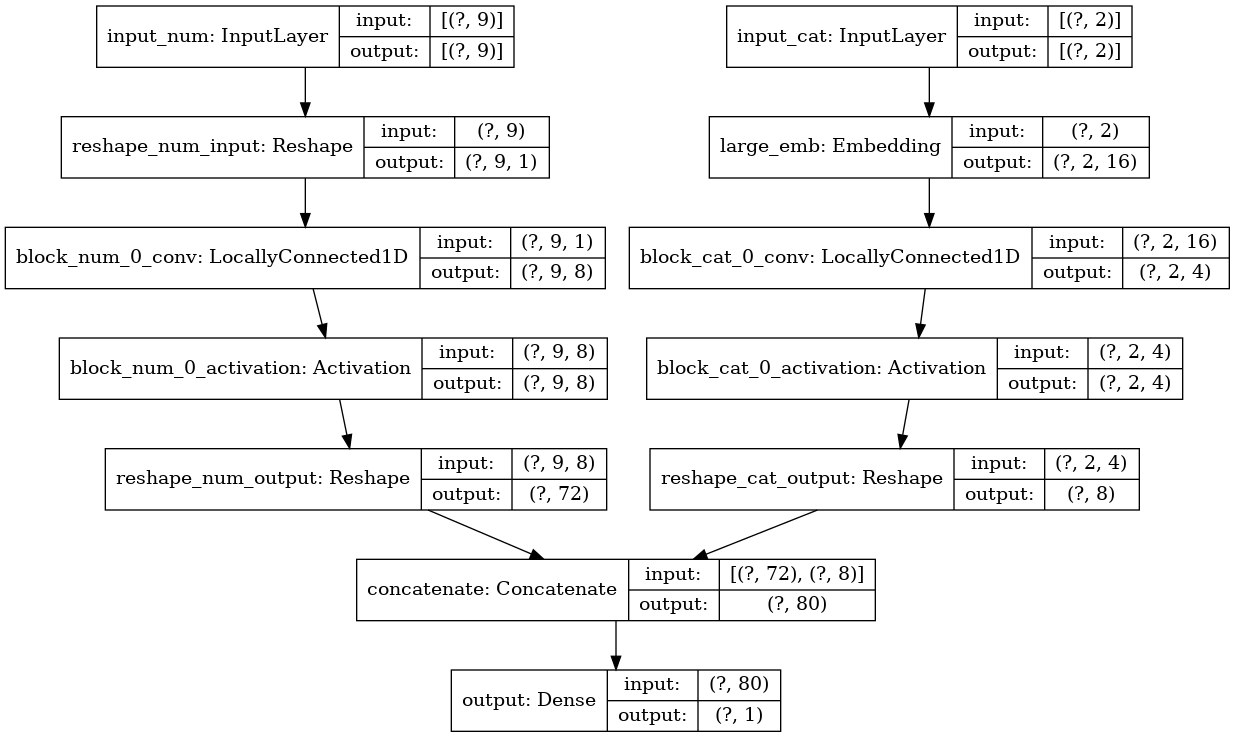

<IPython.core.display.Javascript object>

In [21]:
plot_model(
    model,
    # to_file="model.png",
    show_shapes=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
)

In [22]:
y_train.shape

(1310,)

<IPython.core.display.Javascript object>

In [23]:
counts = np.unique(y_train, return_counts=True)[1]
counts = counts.sum() / counts

<IPython.core.display.Javascript object>

In [24]:
class_weight = {}
for i, counts in enumerate(counts):
    class_weight[i] = counts
class_weight

{0: 145.55555555555554,
 1: 28.47826086956522,
 2: 2.347670250896057,
 3: 2.5387596899224807,
 4: 7.844311377245509,
 5: 93.57142857142857}

<IPython.core.display.Javascript object>

In [25]:
%%time
history = model.fit(
    input_train,
    y_train.reshape(-1, 1),
    epochs=2000,
    batch_size=1024,
    validation_data=(input_valid, y_valid.reshape(-1, 1),),
    verbose=2,
    callbacks=[EarlyStopping(monitor="val_loss", patience=50, verbose=1)],
    #class_weight=None#class_weight
)

Epoch 1/2000
2/2 - 0s - loss: 32.2739 - val_loss: 32.1564
Epoch 2/2000
2/2 - 0s - loss: 32.0166 - val_loss: 31.8979
Epoch 3/2000
2/2 - 0s - loss: 31.7611 - val_loss: 32.0914
Epoch 4/2000
2/2 - 0s - loss: 31.9802 - val_loss: 32.0888
Epoch 5/2000
2/2 - 0s - loss: 31.9778 - val_loss: 32.0855
Epoch 6/2000
2/2 - 0s - loss: 31.9747 - val_loss: 32.0864
Epoch 7/2000
2/2 - 0s - loss: 31.9755 - val_loss: 32.0818
Epoch 8/2000
2/2 - 0s - loss: 31.9713 - val_loss: 32.0768
Epoch 9/2000
2/2 - 0s - loss: 31.9668 - val_loss: 32.0788
Epoch 10/2000
2/2 - 0s - loss: 31.9685 - val_loss: 32.0728
Epoch 11/2000
2/2 - 0s - loss: 31.9631 - val_loss: 32.0664
Epoch 12/2000
2/2 - 0s - loss: 31.9573 - val_loss: 32.0692
Epoch 13/2000
2/2 - 0s - loss: 31.9598 - val_loss: 32.0620
Epoch 14/2000
2/2 - 0s - loss: 31.9534 - val_loss: 32.0545
Epoch 15/2000
2/2 - 0s - loss: 31.9466 - val_loss: 32.0579
Epoch 16/2000
2/2 - 0s - loss: 31.9496 - val_loss: 32.0498
Epoch 17/2000
2/2 - 0s - loss: 31.9423 - val_loss: 32.0414
Epoch 

Epoch 140/2000
2/2 - 0s - loss: 30.4357 - val_loss: 30.3806
Epoch 141/2000
2/2 - 0s - loss: 30.3845 - val_loss: 30.4074
Epoch 142/2000
2/2 - 0s - loss: 30.4099 - val_loss: 30.3530
Epoch 143/2000
2/2 - 0s - loss: 30.3580 - val_loss: 30.2976
Epoch 144/2000
2/2 - 0s - loss: 30.3045 - val_loss: 30.3254
Epoch 145/2000
2/2 - 0s - loss: 30.3310 - val_loss: 30.2691
Epoch 146/2000
2/2 - 0s - loss: 30.2767 - val_loss: 30.2115
Epoch 147/2000
2/2 - 0s - loss: 30.2212 - val_loss: 30.2400
Epoch 148/2000
2/2 - 0s - loss: 30.2488 - val_loss: 30.1809
Epoch 149/2000
2/2 - 0s - loss: 30.1921 - val_loss: 30.1208
Epoch 150/2000
2/2 - 0s - loss: 30.1343 - val_loss: 30.1508
Epoch 151/2000
2/2 - 0s - loss: 30.1629 - val_loss: 30.0894
Epoch 152/2000
2/2 - 0s - loss: 30.1040 - val_loss: 30.0267
Epoch 153/2000
2/2 - 0s - loss: 30.0435 - val_loss: 30.0579
Epoch 154/2000
2/2 - 0s - loss: 30.0735 - val_loss: 29.9940
Epoch 155/2000
2/2 - 0s - loss: 30.0121 - val_loss: 29.9286
Epoch 156/2000
2/2 - 0s - loss: 29.9493 

Epoch 277/2000
2/2 - 0s - loss: 21.9930 - val_loss: 21.6508
Epoch 278/2000
2/2 - 0s - loss: 21.7791 - val_loss: 21.4344
Epoch 279/2000
2/2 - 0s - loss: 21.5637 - val_loss: 21.5426
Epoch 280/2000
2/2 - 0s - loss: 21.6714 - val_loss: 21.3245
Epoch 281/2000
2/2 - 0s - loss: 21.4553 - val_loss: 21.1043
Epoch 282/2000
2/2 - 0s - loss: 21.2359 - val_loss: 21.2149
Epoch 283/2000
2/2 - 0s - loss: 21.3454 - val_loss: 20.9932
Epoch 284/2000
2/2 - 0s - loss: 21.1248 - val_loss: 20.7694
Epoch 285/2000
2/2 - 0s - loss: 20.9023 - val_loss: 20.8814
Epoch 286/2000
2/2 - 0s - loss: 21.0133 - val_loss: 20.6560
Epoch 287/2000
2/2 - 0s - loss: 20.7900 - val_loss: 20.4290
Epoch 288/2000
2/2 - 0s - loss: 20.5639 - val_loss: 20.5428
Epoch 289/2000
2/2 - 0s - loss: 20.6766 - val_loss: 20.3140
Epoch 290/2000
2/2 - 0s - loss: 20.4495 - val_loss: 20.0835
Epoch 291/2000
2/2 - 0s - loss: 20.2199 - val_loss: 20.1987
Epoch 292/2000
2/2 - 0s - loss: 20.3348 - val_loss: 19.9670
Epoch 293/2000
2/2 - 0s - loss: 20.1038 

Epoch 415/2000
2/2 - 0s - loss: 5.8010 - val_loss: 5.5653
Epoch 416/2000
2/2 - 0s - loss: 5.6224 - val_loss: 5.3939
Epoch 417/2000
2/2 - 0s - loss: 5.4464 - val_loss: 5.4804
Epoch 418/2000
2/2 - 0s - loss: 5.5358 - val_loss: 5.3117
Epoch 419/2000
2/2 - 0s - loss: 5.3628 - val_loss: 5.1463
Epoch 420/2000
2/2 - 0s - loss: 5.1931 - val_loss: 5.2300
Epoch 421/2000
2/2 - 0s - loss: 5.2777 - val_loss: 5.0673
Epoch 422/2000
2/2 - 0s - loss: 5.1117 - val_loss: 4.9068
Epoch 423/2000
2/2 - 0s - loss: 4.9465 - val_loss: 4.9874
Epoch 424/2000
2/2 - 0s - loss: 5.0298 - val_loss: 4.8294
Epoch 425/2000
2/2 - 0s - loss: 4.8675 - val_loss: 4.6741
Epoch 426/2000
2/2 - 0s - loss: 4.7085 - val_loss: 4.7526
Epoch 427/2000
2/2 - 0s - loss: 4.7881 - val_loss: 4.6005
Epoch 428/2000
2/2 - 0s - loss: 4.6325 - val_loss: 4.4509
Epoch 429/2000
2/2 - 0s - loss: 4.4784 - val_loss: 4.5260
Epoch 430/2000
2/2 - 0s - loss: 4.5568 - val_loss: 4.3787
Epoch 431/2000
2/2 - 0s - loss: 4.4048 - val_loss: 4.2346
Epoch 432/2000

2/2 - 0s - loss: 0.7777 - val_loss: 0.9717
Epoch 557/2000
2/2 - 0s - loss: 0.7695 - val_loss: 0.9660
Epoch 558/2000
2/2 - 0s - loss: 0.7618 - val_loss: 0.9691
Epoch 559/2000
2/2 - 0s - loss: 0.7656 - val_loss: 0.9637
Epoch 560/2000
2/2 - 0s - loss: 0.7583 - val_loss: 0.9587
Epoch 561/2000
2/2 - 0s - loss: 0.7514 - val_loss: 0.9613
Epoch 562/2000
2/2 - 0s - loss: 0.7549 - val_loss: 0.9565
Epoch 563/2000
2/2 - 0s - loss: 0.7482 - val_loss: 0.9522
Epoch 564/2000
2/2 - 0s - loss: 0.7419 - val_loss: 0.9545
Epoch 565/2000
2/2 - 0s - loss: 0.7451 - val_loss: 0.9507
Epoch 566/2000
2/2 - 0s - loss: 0.7389 - val_loss: 0.9469
Epoch 567/2000
2/2 - 0s - loss: 0.7332 - val_loss: 0.9488
Epoch 568/2000
2/2 - 0s - loss: 0.7360 - val_loss: 0.9450
Epoch 569/2000
2/2 - 0s - loss: 0.7303 - val_loss: 0.9414
Epoch 570/2000
2/2 - 0s - loss: 0.7249 - val_loss: 0.9432
Epoch 571/2000
2/2 - 0s - loss: 0.7276 - val_loss: 0.9400
Epoch 572/2000
2/2 - 0s - loss: 0.7223 - val_loss: 0.9369
Epoch 573/2000
2/2 - 0s - los

Epoch 698/2000
2/2 - 0s - loss: 0.5894 - val_loss: 0.8755
Epoch 699/2000
2/2 - 0s - loss: 0.5883 - val_loss: 0.8757
Epoch 700/2000
2/2 - 0s - loss: 0.5889 - val_loss: 0.8751
Epoch 701/2000
2/2 - 0s - loss: 0.5878 - val_loss: 0.8745
Epoch 702/2000
2/2 - 0s - loss: 0.5867 - val_loss: 0.8748
Epoch 703/2000
2/2 - 0s - loss: 0.5872 - val_loss: 0.8743
Epoch 704/2000
2/2 - 0s - loss: 0.5861 - val_loss: 0.8737
Epoch 705/2000
2/2 - 0s - loss: 0.5851 - val_loss: 0.8740
Epoch 706/2000
2/2 - 0s - loss: 0.5856 - val_loss: 0.8734
Epoch 707/2000
2/2 - 0s - loss: 0.5845 - val_loss: 0.8729
Epoch 708/2000
2/2 - 0s - loss: 0.5834 - val_loss: 0.8731
Epoch 709/2000
2/2 - 0s - loss: 0.5840 - val_loss: 0.8726
Epoch 710/2000
2/2 - 0s - loss: 0.5830 - val_loss: 0.8719
Epoch 711/2000
2/2 - 0s - loss: 0.5819 - val_loss: 0.8722
Epoch 712/2000
2/2 - 0s - loss: 0.5824 - val_loss: 0.8717
Epoch 713/2000
2/2 - 0s - loss: 0.5814 - val_loss: 0.8711
Epoch 714/2000
2/2 - 0s - loss: 0.5804 - val_loss: 0.8714
Epoch 715/2000

2/2 - 0s - loss: 0.5269 - val_loss: 0.8323
Epoch 840/2000
2/2 - 0s - loss: 0.5261 - val_loss: 0.8326
Epoch 841/2000
2/2 - 0s - loss: 0.5265 - val_loss: 0.8318
Epoch 842/2000
2/2 - 0s - loss: 0.5258 - val_loss: 0.8309
Epoch 843/2000
2/2 - 0s - loss: 0.5250 - val_loss: 0.8313
Epoch 844/2000
2/2 - 0s - loss: 0.5254 - val_loss: 0.8305
Epoch 845/2000
2/2 - 0s - loss: 0.5246 - val_loss: 0.8297
Epoch 846/2000
2/2 - 0s - loss: 0.5239 - val_loss: 0.8302
Epoch 847/2000
2/2 - 0s - loss: 0.5242 - val_loss: 0.8293
Epoch 848/2000
2/2 - 0s - loss: 0.5234 - val_loss: 0.8285
Epoch 849/2000
2/2 - 0s - loss: 0.5227 - val_loss: 0.8289
Epoch 850/2000
2/2 - 0s - loss: 0.5231 - val_loss: 0.8282
Epoch 851/2000
2/2 - 0s - loss: 0.5223 - val_loss: 0.8274
Epoch 852/2000
2/2 - 0s - loss: 0.5215 - val_loss: 0.8277
Epoch 853/2000
2/2 - 0s - loss: 0.5219 - val_loss: 0.8269
Epoch 854/2000
2/2 - 0s - loss: 0.5212 - val_loss: 0.8259
Epoch 855/2000
2/2 - 0s - loss: 0.5205 - val_loss: 0.8264
Epoch 856/2000
2/2 - 0s - los

Epoch 981/2000
2/2 - 0s - loss: 0.4781 - val_loss: 0.7859
Epoch 982/2000
2/2 - 0s - loss: 0.4784 - val_loss: 0.7851
Epoch 983/2000
2/2 - 0s - loss: 0.4778 - val_loss: 0.7844
Epoch 984/2000
2/2 - 0s - loss: 0.4772 - val_loss: 0.7848
Epoch 985/2000
2/2 - 0s - loss: 0.4775 - val_loss: 0.7842
Epoch 986/2000
2/2 - 0s - loss: 0.4769 - val_loss: 0.7836
Epoch 987/2000
2/2 - 0s - loss: 0.4763 - val_loss: 0.7839
Epoch 988/2000
2/2 - 0s - loss: 0.4766 - val_loss: 0.7832
Epoch 989/2000
2/2 - 0s - loss: 0.4760 - val_loss: 0.7826
Epoch 990/2000
2/2 - 0s - loss: 0.4754 - val_loss: 0.7830
Epoch 991/2000
2/2 - 0s - loss: 0.4757 - val_loss: 0.7825
Epoch 992/2000
2/2 - 0s - loss: 0.4751 - val_loss: 0.7819
Epoch 993/2000
2/2 - 0s - loss: 0.4745 - val_loss: 0.7823
Epoch 994/2000
2/2 - 0s - loss: 0.4748 - val_loss: 0.7819
Epoch 995/2000
2/2 - 0s - loss: 0.4742 - val_loss: 0.7815
Epoch 996/2000
2/2 - 0s - loss: 0.4737 - val_loss: 0.7817
Epoch 997/2000
2/2 - 0s - loss: 0.4740 - val_loss: 0.7814
Epoch 998/2000

2/2 - 0s - loss: 0.4459 - val_loss: 0.7508
Epoch 1121/2000
2/2 - 0s - loss: 0.4456 - val_loss: 0.7505
Epoch 1122/2000
2/2 - 0s - loss: 0.4452 - val_loss: 0.7506
Epoch 1123/2000
2/2 - 0s - loss: 0.4454 - val_loss: 0.7503
Epoch 1124/2000
2/2 - 0s - loss: 0.4451 - val_loss: 0.7500
Epoch 1125/2000
2/2 - 0s - loss: 0.4447 - val_loss: 0.7501
Epoch 1126/2000
2/2 - 0s - loss: 0.4449 - val_loss: 0.7499
Epoch 1127/2000
2/2 - 0s - loss: 0.4445 - val_loss: 0.7495
Epoch 1128/2000
2/2 - 0s - loss: 0.4442 - val_loss: 0.7496
Epoch 1129/2000
2/2 - 0s - loss: 0.4444 - val_loss: 0.7490
Epoch 1130/2000
2/2 - 0s - loss: 0.4440 - val_loss: 0.7485
Epoch 1131/2000
2/2 - 0s - loss: 0.4436 - val_loss: 0.7488
Epoch 1132/2000
2/2 - 0s - loss: 0.4438 - val_loss: 0.7481
Epoch 1133/2000
2/2 - 0s - loss: 0.4435 - val_loss: 0.7475
Epoch 1134/2000
2/2 - 0s - loss: 0.4432 - val_loss: 0.7479
Epoch 1135/2000
2/2 - 0s - loss: 0.4433 - val_loss: 0.7476
Epoch 1136/2000
2/2 - 0s - loss: 0.4430 - val_loss: 0.7473
Epoch 1137/20

2/2 - 0s - loss: 0.4259 - val_loss: 0.7281
Epoch 1260/2000
2/2 - 0s - loss: 0.4257 - val_loss: 0.7283
Epoch 1261/2000
2/2 - 0s - loss: 0.4258 - val_loss: 0.7279
Epoch 1262/2000
2/2 - 0s - loss: 0.4255 - val_loss: 0.7274
Epoch 1263/2000
2/2 - 0s - loss: 0.4253 - val_loss: 0.7276
Epoch 1264/2000
2/2 - 0s - loss: 0.4254 - val_loss: 0.7272
Epoch 1265/2000
2/2 - 0s - loss: 0.4252 - val_loss: 0.7269
Epoch 1266/2000
2/2 - 0s - loss: 0.4250 - val_loss: 0.7271
Epoch 1267/2000
2/2 - 0s - loss: 0.4251 - val_loss: 0.7269
Epoch 1268/2000
2/2 - 0s - loss: 0.4249 - val_loss: 0.7266
Epoch 1269/2000
2/2 - 0s - loss: 0.4246 - val_loss: 0.7267
Epoch 1270/2000
2/2 - 0s - loss: 0.4247 - val_loss: 0.7263
Epoch 1271/2000
2/2 - 0s - loss: 0.4245 - val_loss: 0.7260
Epoch 1272/2000
2/2 - 0s - loss: 0.4243 - val_loss: 0.7262
Epoch 1273/2000
2/2 - 0s - loss: 0.4244 - val_loss: 0.7260
Epoch 1274/2000
2/2 - 0s - loss: 0.4242 - val_loss: 0.7258
Epoch 1275/2000
2/2 - 0s - loss: 0.4240 - val_loss: 0.7259
Epoch 1276/20

2/2 - 0s - loss: 0.4117 - val_loss: 0.7117
Epoch 1399/2000
2/2 - 0s - loss: 0.4118 - val_loss: 0.7116
Epoch 1400/2000
2/2 - 0s - loss: 0.4116 - val_loss: 0.7115
Epoch 1401/2000
2/2 - 0s - loss: 0.4115 - val_loss: 0.7115
Epoch 1402/2000
2/2 - 0s - loss: 0.4115 - val_loss: 0.7115
Epoch 1403/2000
2/2 - 0s - loss: 0.4113 - val_loss: 0.7115
Epoch 1404/2000
2/2 - 0s - loss: 0.4112 - val_loss: 0.7115
Epoch 1405/2000
2/2 - 0s - loss: 0.4112 - val_loss: 0.7116
Epoch 1406/2000
2/2 - 0s - loss: 0.4111 - val_loss: 0.7116
Epoch 1407/2000
2/2 - 0s - loss: 0.4109 - val_loss: 0.7115
Epoch 1408/2000
2/2 - 0s - loss: 0.4110 - val_loss: 0.7113
Epoch 1409/2000
2/2 - 0s - loss: 0.4108 - val_loss: 0.7110
Epoch 1410/2000
2/2 - 0s - loss: 0.4106 - val_loss: 0.7111
Epoch 1411/2000
2/2 - 0s - loss: 0.4107 - val_loss: 0.7107
Epoch 1412/2000
2/2 - 0s - loss: 0.4105 - val_loss: 0.7104
Epoch 1413/2000
2/2 - 0s - loss: 0.4104 - val_loss: 0.7106
Epoch 1414/2000
2/2 - 0s - loss: 0.4104 - val_loss: 0.7104
Epoch 1415/20

Epoch 1538/2000
2/2 - 0s - loss: 0.3994 - val_loss: 0.7032
Epoch 1539/2000
2/2 - 0s - loss: 0.3992 - val_loss: 0.7030
Epoch 1540/2000
2/2 - 0s - loss: 0.3993 - val_loss: 0.7033
Epoch 1541/2000
2/2 - 0s - loss: 0.3991 - val_loss: 0.7034
Epoch 1542/2000
2/2 - 0s - loss: 0.3989 - val_loss: 0.7032
Epoch 1543/2000
2/2 - 0s - loss: 0.3990 - val_loss: 0.7031
Epoch 1544/2000
2/2 - 0s - loss: 0.3989 - val_loss: 0.7028
Epoch 1545/2000
2/2 - 0s - loss: 0.3987 - val_loss: 0.7029
Epoch 1546/2000
2/2 - 0s - loss: 0.3987 - val_loss: 0.7029
Epoch 1547/2000
2/2 - 0s - loss: 0.3986 - val_loss: 0.7030
Epoch 1548/2000
2/2 - 0s - loss: 0.3984 - val_loss: 0.7030
Epoch 1549/2000
2/2 - 0s - loss: 0.3985 - val_loss: 0.7031
Epoch 1550/2000
2/2 - 0s - loss: 0.3983 - val_loss: 0.7030
Epoch 1551/2000
2/2 - 0s - loss: 0.3981 - val_loss: 0.7027
Epoch 1552/2000
2/2 - 0s - loss: 0.3983 - val_loss: 0.7022
Epoch 1553/2000
2/2 - 0s - loss: 0.3980 - val_loss: 0.7019
Epoch 1554/2000
2/2 - 0s - loss: 0.3979 - val_loss: 0.70

Epoch 1677/2000
2/2 - 0s - loss: 0.3871 - val_loss: 0.6947
Epoch 1678/2000
2/2 - 0s - loss: 0.3871 - val_loss: 0.6945
Epoch 1679/2000
2/2 - 0s - loss: 0.3870 - val_loss: 0.6942
Epoch 1680/2000
2/2 - 0s - loss: 0.3868 - val_loss: 0.6943
Epoch 1681/2000
2/2 - 0s - loss: 0.3869 - val_loss: 0.6942
Epoch 1682/2000
2/2 - 0s - loss: 0.3867 - val_loss: 0.6940
Epoch 1683/2000
2/2 - 0s - loss: 0.3865 - val_loss: 0.6940
Epoch 1684/2000
2/2 - 0s - loss: 0.3866 - val_loss: 0.6937
Epoch 1685/2000
2/2 - 0s - loss: 0.3864 - val_loss: 0.6933
Epoch 1686/2000
2/2 - 0s - loss: 0.3862 - val_loss: 0.6933
Epoch 1687/2000
2/2 - 0s - loss: 0.3863 - val_loss: 0.6928
Epoch 1688/2000
2/2 - 0s - loss: 0.3862 - val_loss: 0.6923
Epoch 1689/2000
2/2 - 0s - loss: 0.3860 - val_loss: 0.6926
Epoch 1690/2000
2/2 - 0s - loss: 0.3861 - val_loss: 0.6922
Epoch 1691/2000
2/2 - 0s - loss: 0.3859 - val_loss: 0.6918
Epoch 1692/2000
2/2 - 0s - loss: 0.3858 - val_loss: 0.6921
Epoch 1693/2000
2/2 - 0s - loss: 0.3858 - val_loss: 0.69

Epoch 1816/2000
2/2 - 0s - loss: 0.3753 - val_loss: 0.6863
Epoch 1817/2000
2/2 - 0s - loss: 0.3751 - val_loss: 0.6860
Epoch 1818/2000
2/2 - 0s - loss: 0.3750 - val_loss: 0.6861
Epoch 1819/2000
2/2 - 0s - loss: 0.3750 - val_loss: 0.6859
Epoch 1820/2000
2/2 - 0s - loss: 0.3749 - val_loss: 0.6860
Epoch 1821/2000
2/2 - 0s - loss: 0.3747 - val_loss: 0.6861
Epoch 1822/2000
2/2 - 0s - loss: 0.3748 - val_loss: 0.6862
Epoch 1823/2000
2/2 - 0s - loss: 0.3746 - val_loss: 0.6863
Epoch 1824/2000
2/2 - 0s - loss: 0.3745 - val_loss: 0.6862
Epoch 1825/2000
2/2 - 0s - loss: 0.3745 - val_loss: 0.6862
Epoch 1826/2000
2/2 - 0s - loss: 0.3744 - val_loss: 0.6862
Epoch 1827/2000
2/2 - 0s - loss: 0.3742 - val_loss: 0.6862
Epoch 1828/2000
2/2 - 0s - loss: 0.3743 - val_loss: 0.6862
Epoch 1829/2000
2/2 - 0s - loss: 0.3741 - val_loss: 0.6861
Epoch 1830/2000
2/2 - 0s - loss: 0.3740 - val_loss: 0.6862
Epoch 1831/2000
2/2 - 0s - loss: 0.3741 - val_loss: 0.6864
Epoch 1832/2000
2/2 - 0s - loss: 0.3739 - val_loss: 0.68

<IPython.core.display.Javascript object>

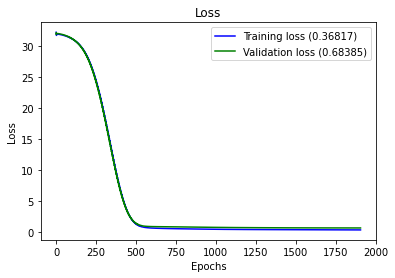

<IPython.core.display.Javascript object>

In [26]:
plot_history(history)

In [27]:
model_auc = mean_absolute_error(
    y_pred=model.predict(input_valid).reshape(-1), y_true=y_valid
)
model_auc

0.5686252625413644

<IPython.core.display.Javascript object>

In [28]:
model_auc = mean_squared_error(
    y_pred=model.predict(input_valid).reshape(-1), y_true=y_valid
)
model_auc

0.6838507386196302

<IPython.core.display.Javascript object>

In [29]:
model_auc = mean_absolute_error(
    y_pred=model.predict(input_test).reshape(-1), y_true=y_test
)
model_auc

0.49195781350135803

<IPython.core.display.Javascript object>

In [30]:
model_auc = mean_squared_error(
    y_pred=model.predict(input_test).reshape(-1), y_true=y_test
)
model_auc

0.5065062456342929

<IPython.core.display.Javascript object>

In [31]:
from xplainet.model import predict, encode

<IPython.core.display.Javascript object>

In [32]:
probs, explanations = predict(model, input_test)

<IPython.core.display.Javascript object>

In [33]:
probs, encoded_output = encode(model, input_test)

<IPython.core.display.Javascript object>

In [34]:
y_test.shape

(160,)

<IPython.core.display.Javascript object>

In [35]:
encoded_output.shape

(160, 80)

<IPython.core.display.Javascript object>

In [36]:
explanations.shape

(160, 11)

<IPython.core.display.Javascript object>

In [37]:
import matplotlib.pyplot as plt

# plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt


def explain_plot(importances, columns):
    selection = np.argsort(-np.absolute(importances))[:10]
    # indexes = np.argsort(importances)
    performance = importances[selection]
    #     print(performance.shape)512, 256, 128, 64, 32, 1
    y_pos = np.arange(performance.shape[0])

    plt.barh(y_pos, performance, align="center", alpha=0.5)
    plt.yticks(y_pos, columns[selection])
    # plt.xlabel('Usage')
    plt.title("Feature importance")

    plt.show()

<IPython.core.display.Javascript object>

In [38]:
all_cols = np.array(params["bool_cols"] + params["num_cols"] + params["cat_cols"])
all_cols

array(['citric acid', 'volatile acidity', 'pH', 'chlorides',
       'fixed acidity', 'sulphates', 'total sulfur dioxide',
       'residual sugar', 'density', 'free sulfur dioxide', 'alcohol'],
      dtype='<U20')

<IPython.core.display.Javascript object>

## Explain global

In [39]:
# Looks like this is broken for now.

<IPython.core.display.Javascript object>

In [40]:
probs_train, explanations_train = predict(model, input_train)

<IPython.core.display.Javascript object>

In [41]:
global_explain = np.abs(explanations_train).sum(axis=0)
global_explain = global_explain / np.abs(global_explain).sum()

<IPython.core.display.Javascript object>

In [42]:
global_explain

array([0.09062034, 0.0906155 , 0.09061714, 0.0906186 , 0.09061475,
       0.0906136 , 0.0906184 , 0.09061984, 0.09061975, 0.09091277,
       0.09352931])

<IPython.core.display.Javascript object>

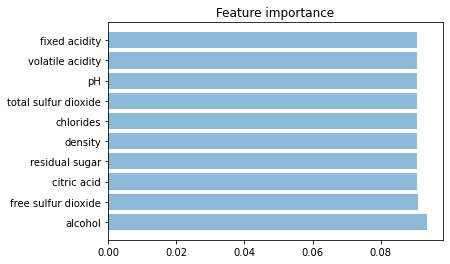

<IPython.core.display.Javascript object>

In [43]:
explain_plot(global_explain, all_cols)

## Explain local

In [44]:
# Looks like this is broken for now.

<IPython.core.display.Javascript object>

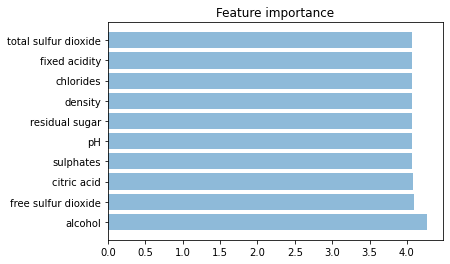

5.069087982177734


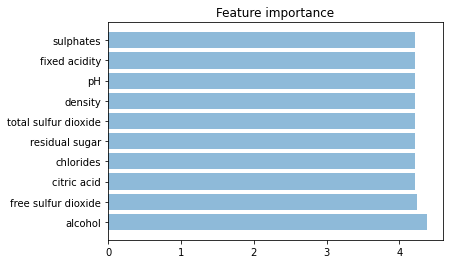

5.2148051261901855


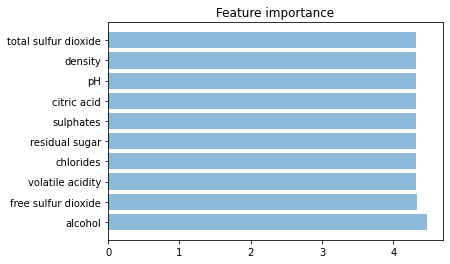

5.317386150360107


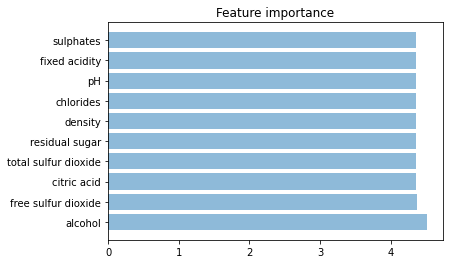

5.355174541473389


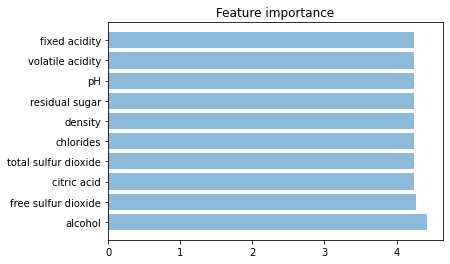

5.241655349731445


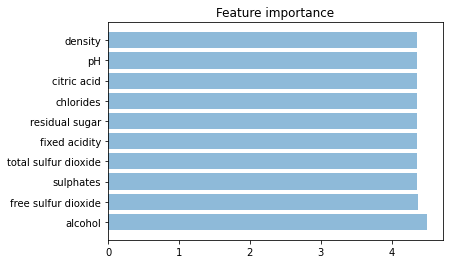

5.353858470916748


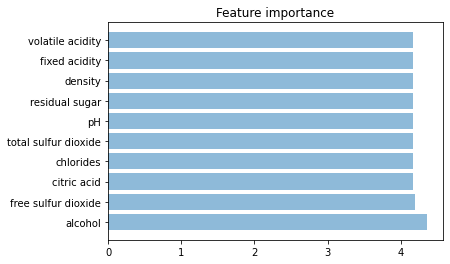

5.16807746887207


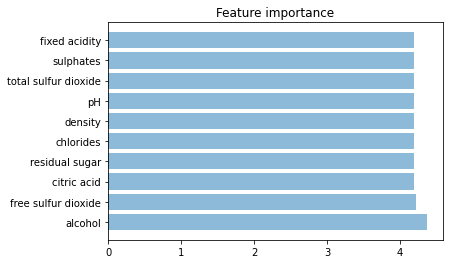

5.189202308654785


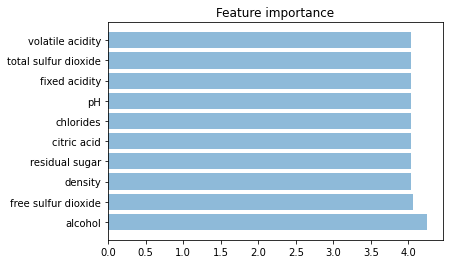

5.033139705657959


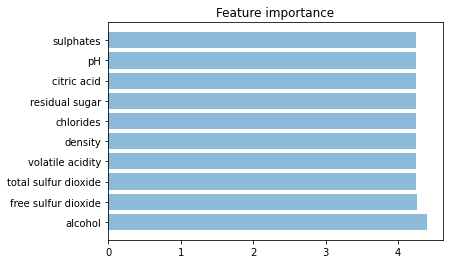

5.238567352294922


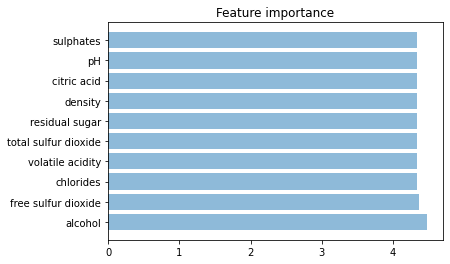

5.336091041564941


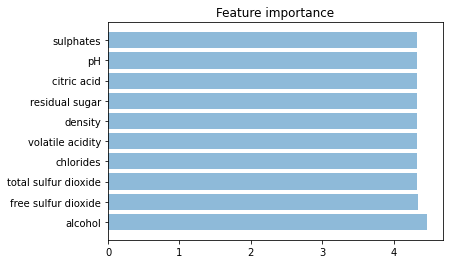

5.319075107574463


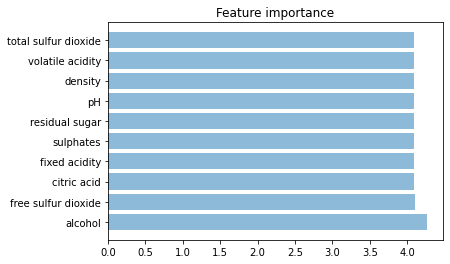

5.081655502319336


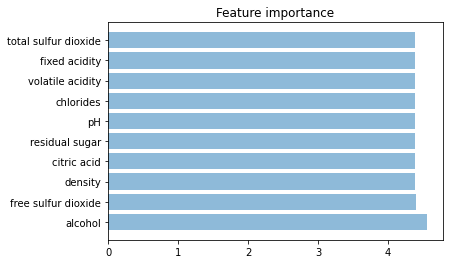

5.374035358428955


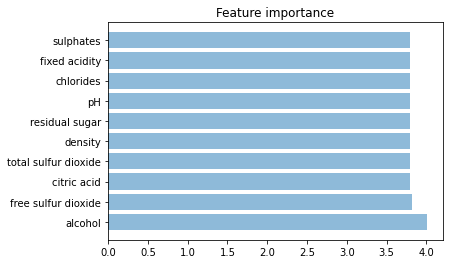

4.789801597595215


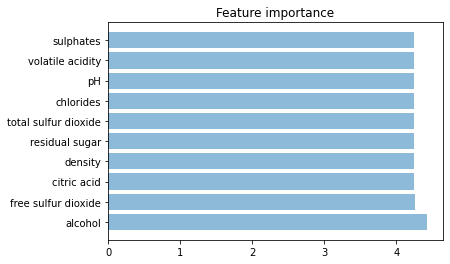

5.231739521026611


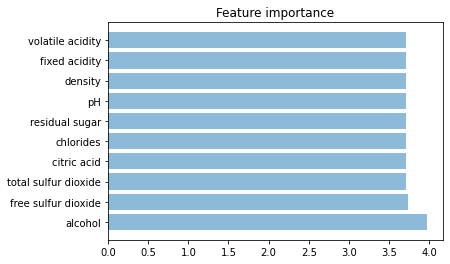

4.700886249542236


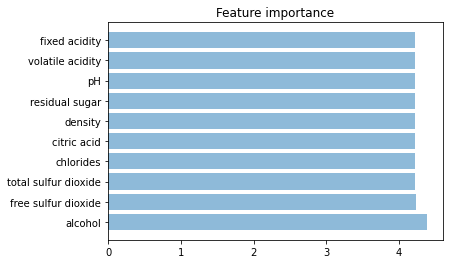

5.2146196365356445


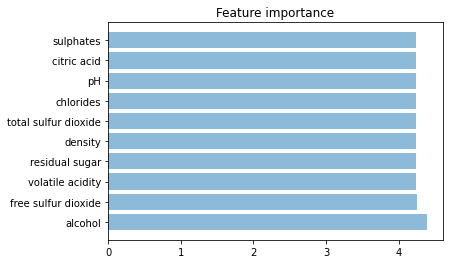

5.227941989898682


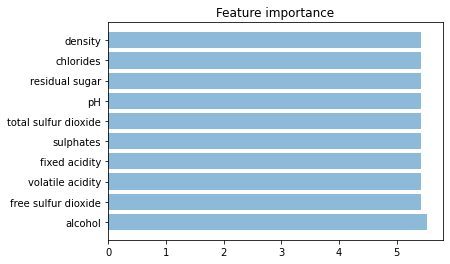

6.416680335998535


<IPython.core.display.Javascript object>

In [45]:
for i in range(20):
    explain_plot(explanations[i], all_cols)
    print(probs[i].item())

In [46]:
from sklearn.metrics import confusion_matrix

<IPython.core.display.Javascript object>

In [47]:
probs_test, explanations_train = predict(model, input_test)

<IPython.core.display.Javascript object>

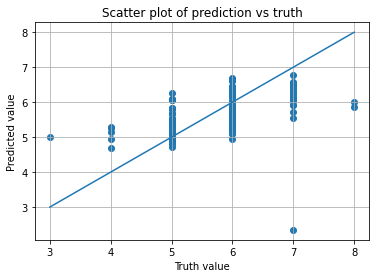

<IPython.core.display.Javascript object>

In [48]:
# plt.barh(y_pos, performance, align="center", alpha=0.5)
# plt.yticks(y_pos, columns[selection])
plt.ylabel("Predicted value")
plt.xlabel("Truth value")

plt.title("Scatter plot of prediction vs truth")
plt.scatter(y_test, probs_test)
plt.plot([np.min(y_test), np.max(y_test)], [np.min(y_test), np.max(y_test)])
plt.grid(True)
plt.show()

In [49]:
probs_test

array([[5.069088 ],
       [5.214805 ],
       [5.317386 ],
       [5.3551745],
       [5.2416553],
       [5.3538585],
       [5.1680775],
       [5.1892023],
       [5.0331397],
       [5.2385674],
       [5.336091 ],
       [5.319075 ],
       [5.0816555],
       [5.3740354],
       [4.7898016],
       [5.2317395],
       [4.7008862],
       [5.2146196],
       [5.227942 ],
       [6.4166803],
       [5.031613 ],
       [5.17529  ],
       [5.877454 ],
       [5.6814184],
       [6.0253625],
       [5.5975757],
       [5.8076997],
       [6.103238 ],
       [5.6306834],
       [5.8069663],
       [6.2362084],
       [5.1557045],
       [5.707019 ],
       [5.387678 ],
       [5.547765 ],
       [5.3661027],
       [5.9552164],
       [6.3972616],
       [6.38364  ],
       [5.932184 ],
       [6.0100226],
       [5.3754535],
       [5.3592234],
       [5.535683 ],
       [6.617005 ],
       [5.946935 ],
       [5.083184 ],
       [5.2588105],
       [4.8494906],
       [5.436124 ],


<IPython.core.display.Javascript object>

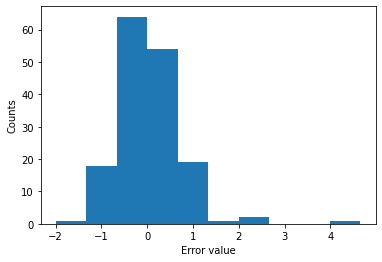

<IPython.core.display.Javascript object>

In [50]:
plt.hist(y_test.reshape(-1) - probs_test.reshape(-1), bins=10)
plt.xlabel("Error value")
plt.ylabel("Counts")
plt.show()

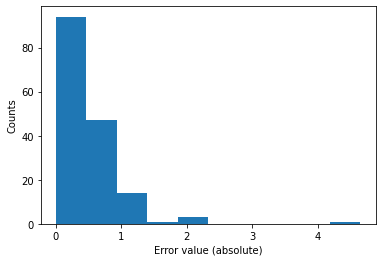

<IPython.core.display.Javascript object>

In [51]:
plt.hist(np.abs(y_test.reshape(-1) - probs_test.reshape(-1)), bins=10)
plt.xlabel("Error value (absolute)")
plt.ylabel("Counts")
plt.show()